Fetching https://www.boxofficemojo.com/holiday/by-year/2020/?grossesOption=calendarGrosses
Fetching https://www.boxofficemojo.com/holiday/by-year/2021/?grossesOption=calendarGrosses
Fetching https://www.boxofficemojo.com/holiday/by-year/2022/?grossesOption=calendarGrosses
Fetching https://www.boxofficemojo.com/holiday/by-year/2023/?grossesOption=calendarGrosses
Fetching https://www.boxofficemojo.com/holiday/by-year/2024/?grossesOption=calendarGrosses


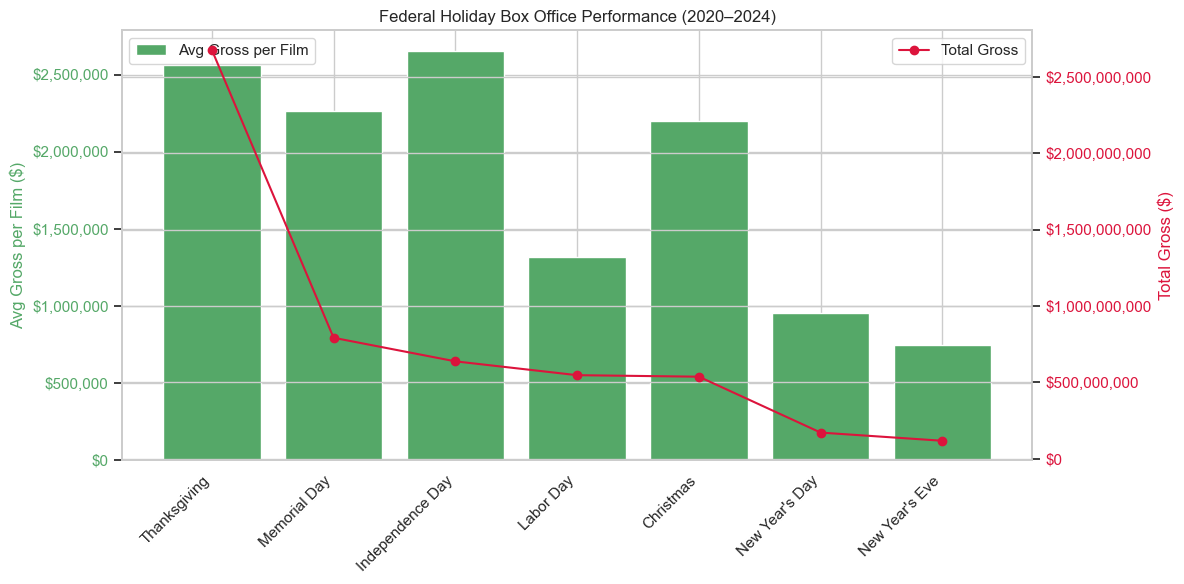

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Apply seaborn style for nicer plot aesthetics
sns.set(style="whitegrid")

# Step 1: Scrape data for holidays from Box Office Mojo for years 2020-2024
base_url = "https://www.boxofficemojo.com/holiday/by-year/{year}/?grossesOption=calendarGrosses"
years = range(2020, 2025)  # Range object for years 2020 to 2024 inclusive
data = []  # List to collect scraped data

for year in years:
    url = base_url.format(year=year)  # Insert year into URL
    print(f"Fetching {url}")
    resp = requests.get(url)  # HTTP GET request to fetch page content
    if resp.status_code != 200:  # Check if request succeeded
        print(f"Failed to retrieve data for {year}")
        continue

    soup = BeautifulSoup(resp.text, "html.parser")  # Parse HTML content
    table = soup.find("table")  # Find first <table> tag which holds the data
    if not table:
        print(f"No table found for {year}")
        continue

    # Extract table headers for column indexing
    headers = [th.get_text(strip=True) for th in table.find_all("th")]
    # Create a dict mapping header name to its index for easy access
    col_indices = {h: i for i, h in enumerate(headers)}

    # Loop over table rows, skipping header row ([1:])
    for row in table.find_all("tr")[1:]:
        cols = row.find_all("td")  # Get all cells in the row
        if len(cols) < len(headers):
            continue  # Skip incomplete rows
        try:
            # Extract holiday name and financial data by column index
            holiday_name = cols[col_indices.get("Holiday", 0)].get_text(strip=True)
            gross_text = cols[col_indices.get("Cumulative Gross", 1)].get_text(strip=True)
            releases_text = cols[col_indices.get("Releases", 2)].get_text(strip=True)

            # Clean string and convert to numeric types
            gross = float(gross_text.replace("$", "").replace(",", ""))
            releases = int(releases_text.replace(",", ""))
        except:
            continue  # Skip rows where conversion fails

        # Standardize holiday names to canonical forms
        holiday_name_lower = holiday_name.lower()
        if "thanksgiving" in holiday_name_lower:
            holiday_name = "Thanksgiving"
        elif "memorial day" in holiday_name_lower:
            holiday_name = "Memorial Day"
        elif "christmas" in holiday_name_lower:
            holiday_name = "Christmas"
        elif "independence day" in holiday_name_lower:
            holiday_name = "Independence Day"
        elif "labor day" in holiday_name_lower:
            holiday_name = "Labor Day"

        # Append cleaned and standardized record to data list
        data.append({"Holiday": holiday_name, "Year": year, "Gross": gross, "Releases": releases})

# Step 2: Convert list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)
if "Holiday" not in df.columns:
    # Sanity check: if scraping failed, alert user
    raise ValueError("No 'Holiday' column found — scraping may have failed.")

# List of keywords to filter holidays we want to analyze
holiday_keywords = [
    "new year's", "martin luther king", "presidents", "memorial",
    "juneteenth", "independence", "labor", "columbus", "veterans", "thanksgiving", "christmas"
]

# Filter rows to keep only holidays containing any of the keywords
filtered = []
for h in df["Holiday"]:
    h_lower = h.lower().strip()
    for kw in holiday_keywords:
        if kw in h_lower:
            filtered.append(True)
            break
    else:
        filtered.append(False)
df = df[filtered]  # Filter DataFrame rows

# Step 3: Group by holiday and aggregate gross and releases data
summary = df.groupby("Holiday").agg({
    "Gross": "sum",  # Sum total gross per holiday across years
    "Releases": "sum"  # Sum total number of releases per holiday
}).reset_index()

# Calculate average gross per film for each holiday
summary["AvgGrossPerFilm"] = summary["Gross"] / summary["Releases"]
# Sort holidays by total gross descending for plotting order
summary = summary.sort_values("Gross", ascending=False).reset_index(drop=True)

# Step 4: Plot dual-axis chart showing average gross per film and total gross

fig, ax1 = plt.subplots(figsize=(12, 6))
x = range(len(summary["Holiday"]))  # X-axis positions

# Pick a darker blue from seaborn palette for bars to improve readability
bar_color = sns.color_palette("deep")[2]

# Plot bar chart on left y-axis for Avg Gross per Film
ax1.bar(x, summary["AvgGrossPerFilm"], color=bar_color, label="Avg Gross per Film")
ax1.set_ylabel("Avg Gross per Film ($)", color=bar_color)
ax1.tick_params(axis='y', labelcolor=bar_color)
ax1.set_xticks(x)
ax1.set_xticklabels(summary["Holiday"], rotation=45, ha="right")  # Rotate x labels for clarity

# Create twin axis sharing x-axis for plotting Total Gross line chart
ax2 = ax1.twinx()
ax2.plot(x, summary["Gross"], color="crimson", marker="o", label="Total Gross")
ax2.set_ylabel("Total Gross ($)", color="crimson")
ax2.tick_params(axis='y', labelcolor="crimson")

# Format y-axis labels as currency with commas and no decimals
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Add legends for both axes
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Federal Holiday Box Office Performance (2020–2024)")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


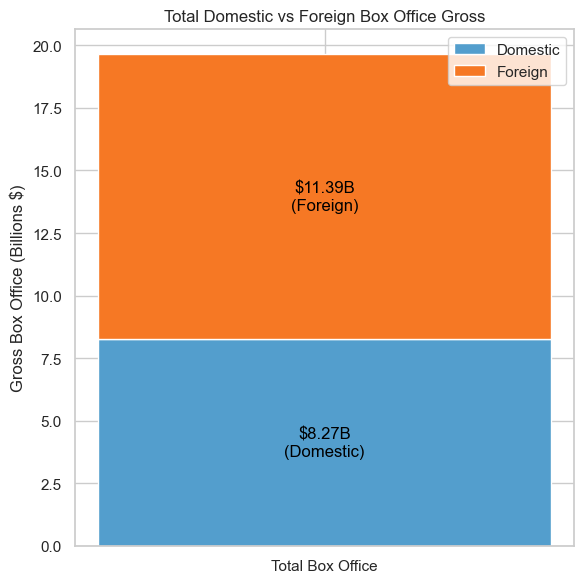

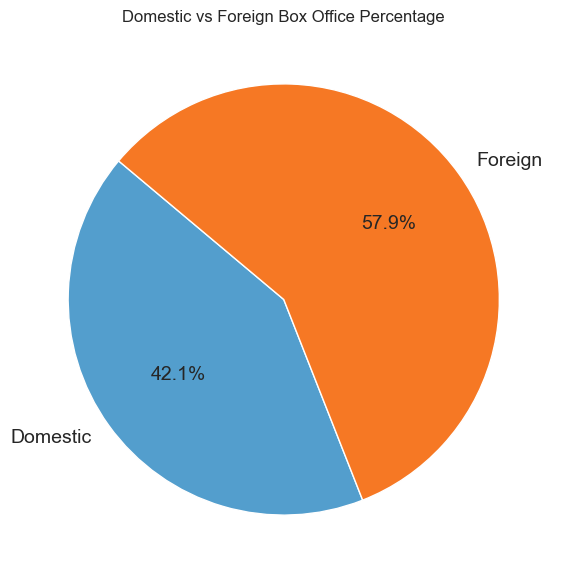

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Scrape box office data for worldwide movies in 2024
url = "https://www.boxofficemojo.com/year/world/2024/"
headers = {
    # Setting User-Agent header to mimic a browser, helps avoid blocking by server
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

rows = soup.find_all("tr")  # Get all table rows (including header)

data = []
for row in rows:  # Loop through all rows
    cells = row.find_all("td")
    if len(cells) < 7:
        # Skip rows without enough columns (header rows or incomplete)
        continue
    
    # Extract text and clean currency and percentage formatting
    title = cells[1].text.strip()
    worldwide = cells[2].text.strip().replace("$","").replace(",","")
    domestic = cells[3].text.strip().replace("$","").replace(",","")
    foreign = cells[5].text.strip().replace("$","").replace(",","")
    foreign_percent = cells[6].text.strip().replace("%","")

    try:
        # Convert numeric strings to floats
        worldwide = float(worldwide)
        domestic = float(domestic)
        foreign = float(foreign)
        foreign_percent = float(foreign_percent)
    except:
        # Skip row if conversion fails
        continue
    
    # Store movie data in a list of dictionaries
    data.append({
        "Title": title,
        "Worldwide": worldwide,
        "Domestic": domestic,
        "Foreign": foreign,
        "ForeignPercent": foreign_percent
    })

# Step 2: Convert data list into DataFrame for easier analysis
df = pd.DataFrame(data)

# Step 3: Calculate total domestic and foreign grosses summed over all movies
total_domestic = df['Domestic'].sum()
total_foreign = df['Foreign'].sum()

# Step 4: Plot stacked bar chart of domestic and foreign totals using seaborn style
sns.set_style("whitegrid")  # Apply seaborn's whitegrid style
fig, ax = plt.subplots(figsize=(6, 6))

# Plot domestic bar first
bar_domestic = ax.bar('Total Box Office', total_domestic / 1e9, label='Domestic', color=sns.color_palette("Blues")[3])

# Plot foreign bar stacked on top of domestic
bar_foreign = ax.bar('Total Box Office', total_foreign / 1e9, bottom=total_domestic / 1e9, label='Foreign', color=sns.color_palette("Oranges")[3])

# Add labels centered inside each bar for readability
ax.text(0, (total_domestic / 1e9) / 2, f"${total_domestic / 1e9:.2f}B\n(Domestic)", ha='center', va='center', fontsize=12, color='black')
ax.text(0, total_domestic / 1e9 + (total_foreign / 1e9) / 2, f"${total_foreign / 1e9:.2f}B\n(Foreign)", ha='center', va='center', fontsize=12, color='black')

# Set labels and title
ax.set_ylabel('Gross Box Office (Billions $)')
ax.set_title('Total Domestic vs Foreign Box Office Gross')
ax.legend()

plt.tight_layout()
plt.show()

# Step 5: Plot a pie chart showing domestic vs foreign gross percentages
labels = ['Domestic', 'Foreign']
sizes = [total_domestic, total_foreign]
colors = [sns.color_palette("Blues")[3], sns.color_palette("Oranges")[3]]

plt.figure(figsize=(7,7))
plt.pie(
    sizes, labels=labels, colors=colors,
    autopct='%1.1f%%', startangle=140,
    textprops={'fontsize': 14}
)
plt.title('Domestic vs Foreign Box Office Percentage')
plt.show()


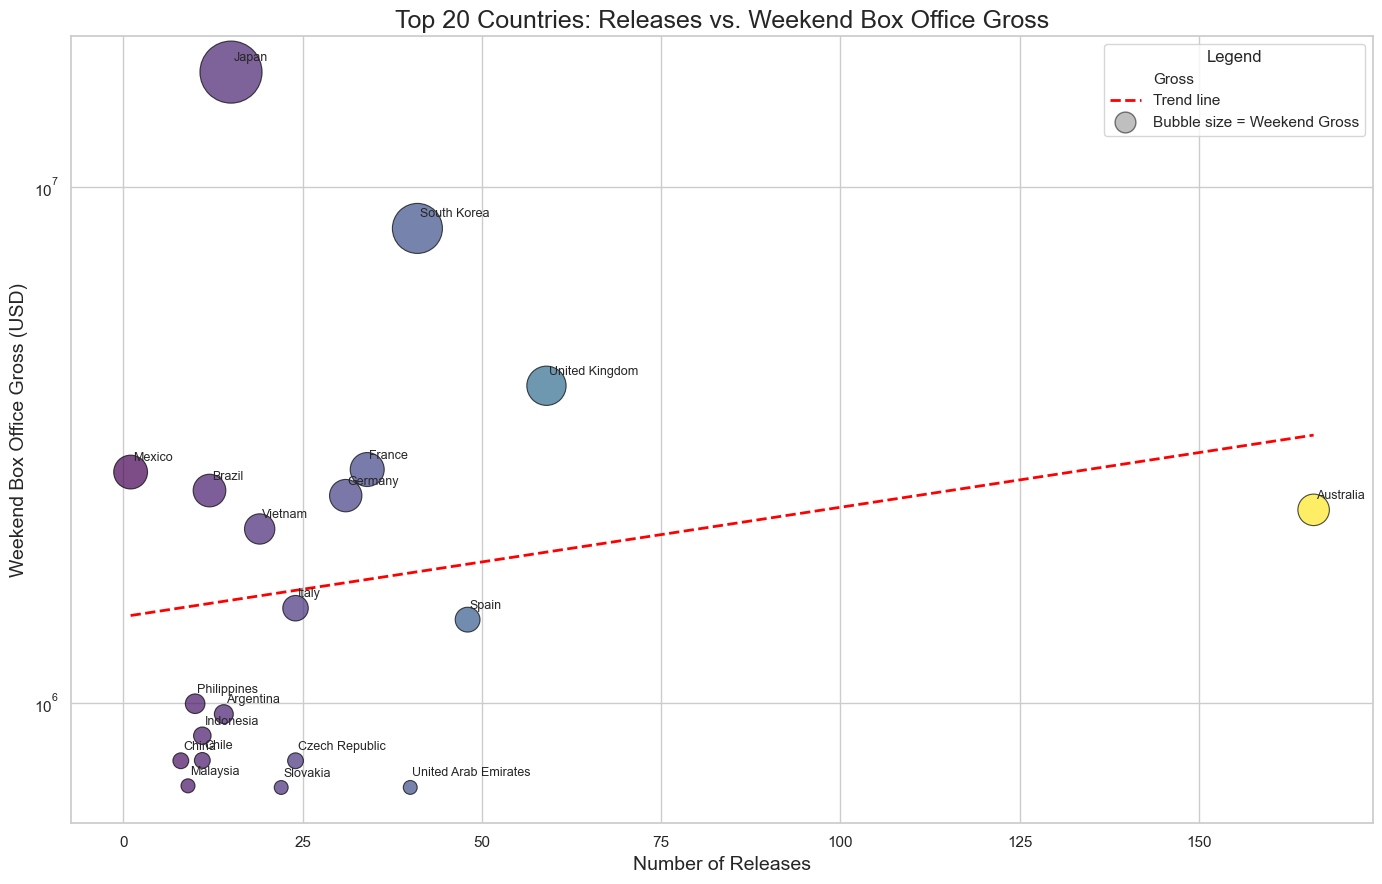

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

# Step 1: Scrape international box office data from Box Office Mojo
url = "https://www.boxofficemojo.com/intl/?ref_=bo_nb_cso_tab"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

data = []
rows = soup.find_all("tr")[1:]  # Skip header row

# Step 2: Parse table rows for country data
for row in rows:
    cells = row.find_all("td")
    if len(cells) < 6:
        continue  # Skip incomplete rows
    country = cells[0].text.strip()
    releases = cells[2].text.strip().replace(",", "")
    gross = cells[5].text.strip().replace("$", "").replace(",", "")

    try:
        releases = int(releases)
        gross = float(gross)
    except ValueError:
        continue

    data.append({"Country": country, "Releases": releases, "Gross": gross})

# Step 3: Create DataFrame and select top 20 countries by gross revenue
df = pd.DataFrame(data)
df = df.sort_values(by="Gross", ascending=False).head(20)

# Step 4: Set seaborn style
sns.set_style('whitegrid')

plt.figure(figsize=(14, 9))

# Step 5: Scatter plot
scatter = sns.scatterplot(
    data=df,
    x="Releases",
    y="Gross",
    size=np.sqrt(df["Gross"]),
    sizes=(100, 2000),
    hue="Releases",
    palette="viridis",
    edgecolor="black",
    alpha=0.7,
    legend="brief"
)

# Keep log scale for clarity but label it better
plt.yscale('log')

# Step 6: Add labels for countries
for i, row in df.iterrows():
    plt.text(row["Releases"] + 0.3, row["Gross"] * 1.05, row["Country"], fontsize=9)

# Step 7: Regression trend line
x = df["Releases"]
y_log = np.log10(df["Gross"])
coef = np.polyfit(x, y_log, 1)
poly1d_fn = np.poly1d(coef)
x_sorted = np.sort(x)
plt.plot(x_sorted, 10**poly1d_fn(x_sorted), color='red', linestyle='--', linewidth=2, label='Trend line')

# Step 8: Custom legend handling
handles, labels = scatter.get_legend_handles_labels()

new_handles = []
new_labels = []
for h, l in zip(handles, labels):
    # Skip the "Releases" hue entries and numeric size ticks
    if "Releases" in l or l == "Number of Releases":
        continue
    elif l.replace('.', '', 1).isdigit():
        continue
    else:
        new_handles.append(h)
        new_labels.append(l)

# Add custom size legend manually
size_legend = [
    Line2D([], [], marker='o', color='w', label='Larger bubble = Higher gross',
           markerfacecolor='gray', markersize=15, alpha=0.5, markeredgecolor='black')
]
new_handles.extend(size_legend)
new_labels.extend(['Bubble size = Weekend Gross'])

plt.legend(new_handles, new_labels, title="Legend", loc='upper right')

# Step 9: Labels and title
plt.xlabel("Number of Releases", fontsize=14)
plt.ylabel("Weekend Box Office Gross (USD)", fontsize=14)  
plt.title("Top 20 Countries: Releases vs. Weekend Box Office Gross", fontsize=18)

plt.tight_layout()
plt.show()


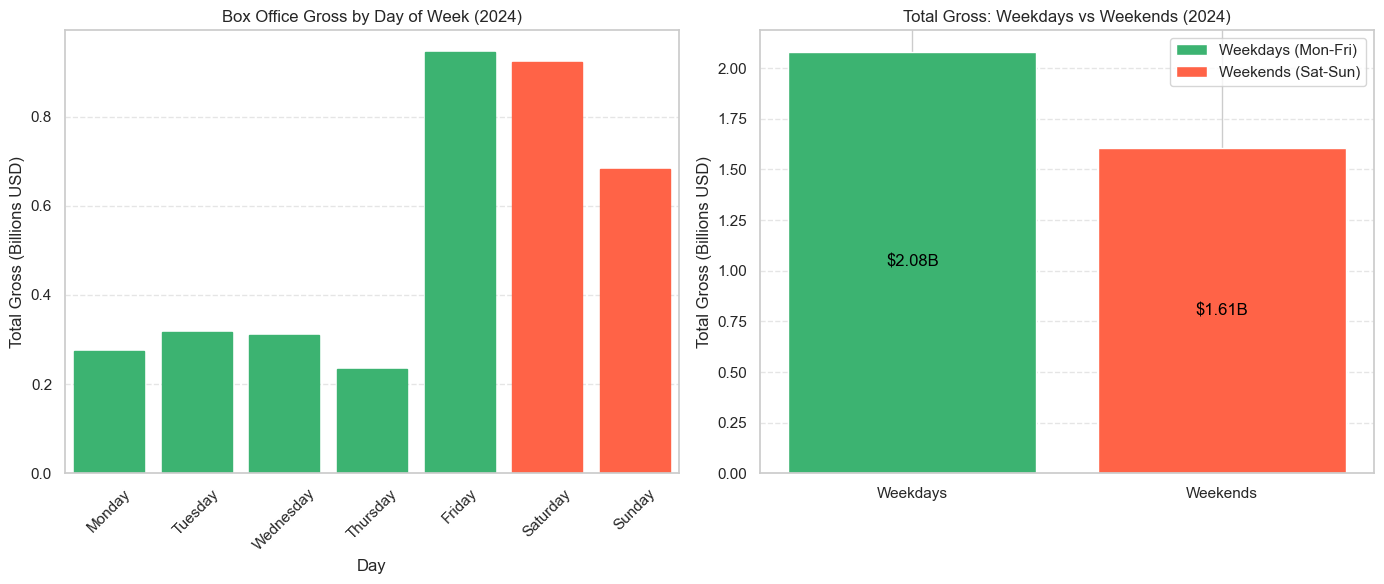

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Scrape daily box office data for 2024 year from Box Office Mojo
url = "https://www.boxofficemojo.com/daily/2024/?view=year"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

# Step 2: Parse the table rows for daily box office data
rows = soup.find_all("tr")
data = []

for row in rows[1:]:  # Skip header row
    cells = row.find_all("td")
    if len(cells) < 9:
        continue  # Skip incomplete rows

    # Extract relevant columns: Date, Day of week, Release title, and Gross
    date = cells[0].text.strip()
    day = cells[1].text.strip()
    release = cells[7].text.strip()
    gross = cells[8].text.strip().replace("$", "").replace(",", "")

    try:
        gross = float(gross)  # Convert gross to float
    except ValueError:
        continue  # Skip rows with invalid gross values

    data.append({"Date": date, "Day": day, "Release": release, "Gross": gross})

# Step 3: Create a DataFrame from the scraped data
df = pd.DataFrame(data)

# Step 4: Group by day of the week and sum grosses
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_summary = df.groupby("Day")["Gross"].sum().reindex(day_order)  # Ensure ordered days

# Define weekend days for coloring
weekend_days = ["Saturday", "Sunday"]

# Step 5: Calculate total grosses for weekdays and weekends separately
weekday_gross = day_summary.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]].sum()
weekend_gross = day_summary.loc[["Saturday", "Sunday"]].sum()

# Step 6: Plot side-by-side charts: gross by individual days and gross by weekday/weekend

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of total gross per individual day (in billions)
bars = sns.barplot(
    x=day_summary.index,
    y=day_summary.values / 1e9,
    ax=ax1,
    dodge=False
)

# Color bars: weekend days in tomato red, weekdays in mediumseagreen
for bar, day in zip(bars.patches, day_summary.index):
    if day in weekend_days:
        bar.set_color("tomato")
    else:
        bar.set_color("mediumseagreen")

# Rotate x-axis labels for readability
plt.setp(ax1.get_xticklabels(), rotation=45)

ax1.set_ylabel("Total Gross (Billions USD)")
ax1.set_title("Box Office Gross by Day of Week (2024)")
ax1.grid(axis="y", linestyle="--", alpha=0.5)

# Stacked bar chart of total gross: weekdays vs weekends (in billions)
ax2.bar("Weekdays", weekday_gross / 1e9, color="mediumseagreen", label="Weekdays (Mon-Fri)")
ax2.bar("Weekends", weekend_gross / 1e9, bottom=0, color="tomato", label="Weekends (Sat-Sun)")

# Add value labels inside bars
ax2.text(0, (weekday_gross / 1e9) / 2, f"${weekday_gross / 1e9:.2f}B", ha='center', va='center', fontsize=12, color='black')
ax2.text(1, (weekend_gross / 1e9) / 2, f"${weekend_gross / 1e9:.2f}B", ha='center', va='center', fontsize=12, color='black')

ax2.set_ylabel("Total Gross (Billions USD)")
ax2.set_title("Total Gross: Weekdays vs Weekends (2024)")
ax2.legend()
ax2.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
